# Deep Learning to Identify Traffic Signs


---
## Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set

In [2]:
num_train, img_height, img_width, img_depth = train['features'].shape

n_train = num_train

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = (img_height, img_width, img_depth)

y_train_set = set(y_train)
y_valid_set = set(y_valid)
y_test_set = set(y_test)
n_classes = len(y_train_set.union(y_valid_set).union(y_test_set))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Sample of each traffic sign

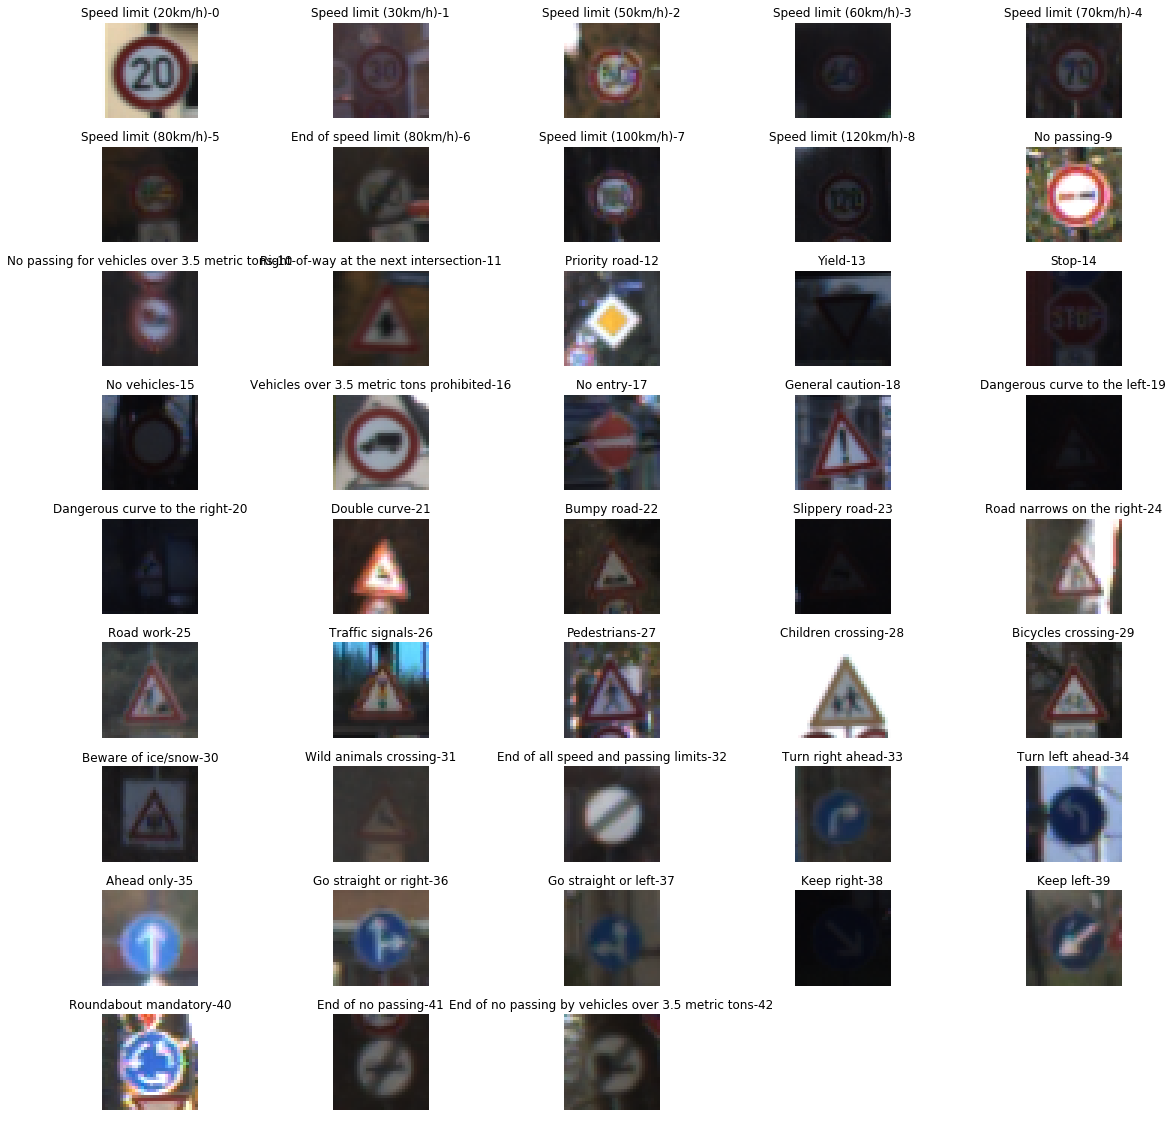

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

signs = dict.fromkeys(range(0, 43))
for k in signs:
    indices = np.where(y_train==k)[0] 
    if indices.any():
        signs[k] = X_train[indices.item(0)]
        continue
    indices = np.where(y_valid==k)[0] 
    if indices.any():
        signs[k] = X_valid[indices.item(0)]
        continue
    indices = np.where(y_test==k)[0] 
    if indices.any():
        signs[k] = X_test[indices.item(0)]

import pandas as pd
csv_file = pd.read_csv('./signnames.csv')
data = csv_file.to_numpy()
signs_name = list(data[:, 1])
        
plt.figure(figsize=(20, 20))
for code, image in signs.items():
    plt.subplot(9, 5, code+1)
    plt.axis("off")
    plt.subplots_adjust(hspace=0.3)
    plt.title(signs_name[code] + '-' + str(code))
    plt.imshow(image)


----

## Deep Learning Architecture (LeNet-5)

Implemenation of deep neural network to identify traffic signs according to [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

A paper titled ["Traffic Sign Recognition with Multi-Scale Convolutional Networks"](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) was used as a baseline for the model and the [LeNet-5 architecture](http://yann.lecun.com/exdb/lenet/) by the same author was implemented here to train the model.

### Preprocess the Data Set (Normalization and shuffling)

In [4]:
from sklearn.utils import shuffle


# Normalize the data
X_train = ((X_train - 127.5) / 127.5)
X_valid = ((X_valid - 127.5) / 127.5)
X_test = ((X_test - 127.5) / 127.5)

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [5]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 695

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2, name='fc2')

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='fc3_b')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43, name='one_hot_y')

In [8]:
rate = 0.002

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits, name='cross_entropy')
loss_operation = tf.reduce_mean(cross_entropy, name='loss_operation')
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='optimizer')
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.


In [9]:
prediction = tf.argmax(logits, 1, name='prediction')
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

### Train, Validate and Test the Model

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.441

EPOCH 2 ...
Validation Accuracy = 0.691

EPOCH 3 ...
Validation Accuracy = 0.786

EPOCH 4 ...
Validation Accuracy = 0.829

EPOCH 5 ...
Validation Accuracy = 0.837

EPOCH 6 ...
Validation Accuracy = 0.866

EPOCH 7 ...
Validation Accuracy = 0.883

EPOCH 8 ...
Validation Accuracy = 0.891

EPOCH 9 ...
Validation Accuracy = 0.898

EPOCH 10 ...
Validation Accuracy = 0.902

EPOCH 11 ...
Validation Accuracy = 0.903

EPOCH 12 ...
Validation Accuracy = 0.907

EPOCH 13 ...
Validation Accuracy = 0.904

EPOCH 14 ...
Validation Accuracy = 0.907

EPOCH 15 ...
Validation Accuracy = 0.900

EPOCH 16 ...
Validation Accuracy = 0.907

EPOCH 17 ...
Validation Accuracy = 0.919

EPOCH 18 ...
Validation Accuracy = 0.921

EPOCH 19 ...
Validation Accuracy = 0.919

EPOCH 20 ...
Validation Accuracy = 0.921

EPOCH 21 ...
Validation Accuracy = 0.917

EPOCH 22 ...
Validation Accuracy = 0.920

EPOCH 23 ...
Validation Accuracy = 0.923

EPOCH 24 ...
Validation Accura

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
CV2:  (32, 32, 3)
imageio:  (32, 32, 3)
Class:  [14]


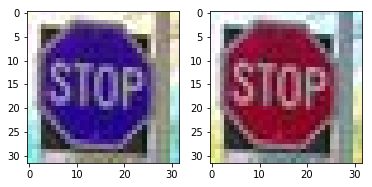

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
      
    import cv2
    stop_cv2 = cv2.imread('./extra_signs/stop-2.jpg')
    plt.subplot(1, 2, 1)
    plt.imshow(stop_cv2)
    
    import imageio
    stop = imageio.imread('./extra_signs/stop-2.jpg')
    plt.subplot(1, 2, 2)
    plt.imshow(stop)
    
    print('CV2: ', stop_cv2.shape)
    print('imageio: ', stop.shape)
#     prediction = tf.get_default_graph().get_tensor_by_name('prediction:0')
#     x = tf.get_default_graph().get_tensor_by_name('x:0')
    
    sign_class = sess.run(prediction, feed_dict={x: np.array([stop])})
    
    print('Class: ', sign_class)